In [1]:
!pip install pymupdf Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 56.1 MB/s eta 0:00:00


In [2]:
from google.colab import files

uploaded = files.upload()

pdf_path = list(uploaded.keys())[0]

Saving Task 2 - AI intern.pdf to Task 2 - AI intern.pdf


In [3]:
import fitz  # PyMuPDF
from PIL import Image
import io

In [4]:
def extract_text_and_images_from_pdf(pdf_path):
    texts = []
    images = []


    doc = fitz.open(pdf_path)

    # each page
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)

        # text
        text = page.get_text()
        if text:
            texts.append(text)

        # images
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            images.append(image)

    return texts, images

Text from Page 1:
Task: Multimodal RAG application
Goal:
Implement a multimodal query processing workflow that handles both text and image
inputs, without relying on OCR for image content extraction. Utilise a multimodal
large language model (LLM) to process retrieved text and images for generating
responses.
Objective:
•
Build a complete pipeline following the given workflow that supports
multimodal content retrieval and generation.
•
Extract both text and image content from documents and embed them into a
shared multimodal vector space.
•
Perform semantic retrieval based on user queries to fetch relevant text and
image data.
•
Feed retrieved images and texts into a multimodal LLM that generates an
answer based on both types of input.
•
Avoid using OCR for image processing; instead, the images should be
processed directly as part of the multimodal input to the LLM.
•
The pipeline should be robust and capable of handling diverse user queries,
reflecting the multimodal approach in every

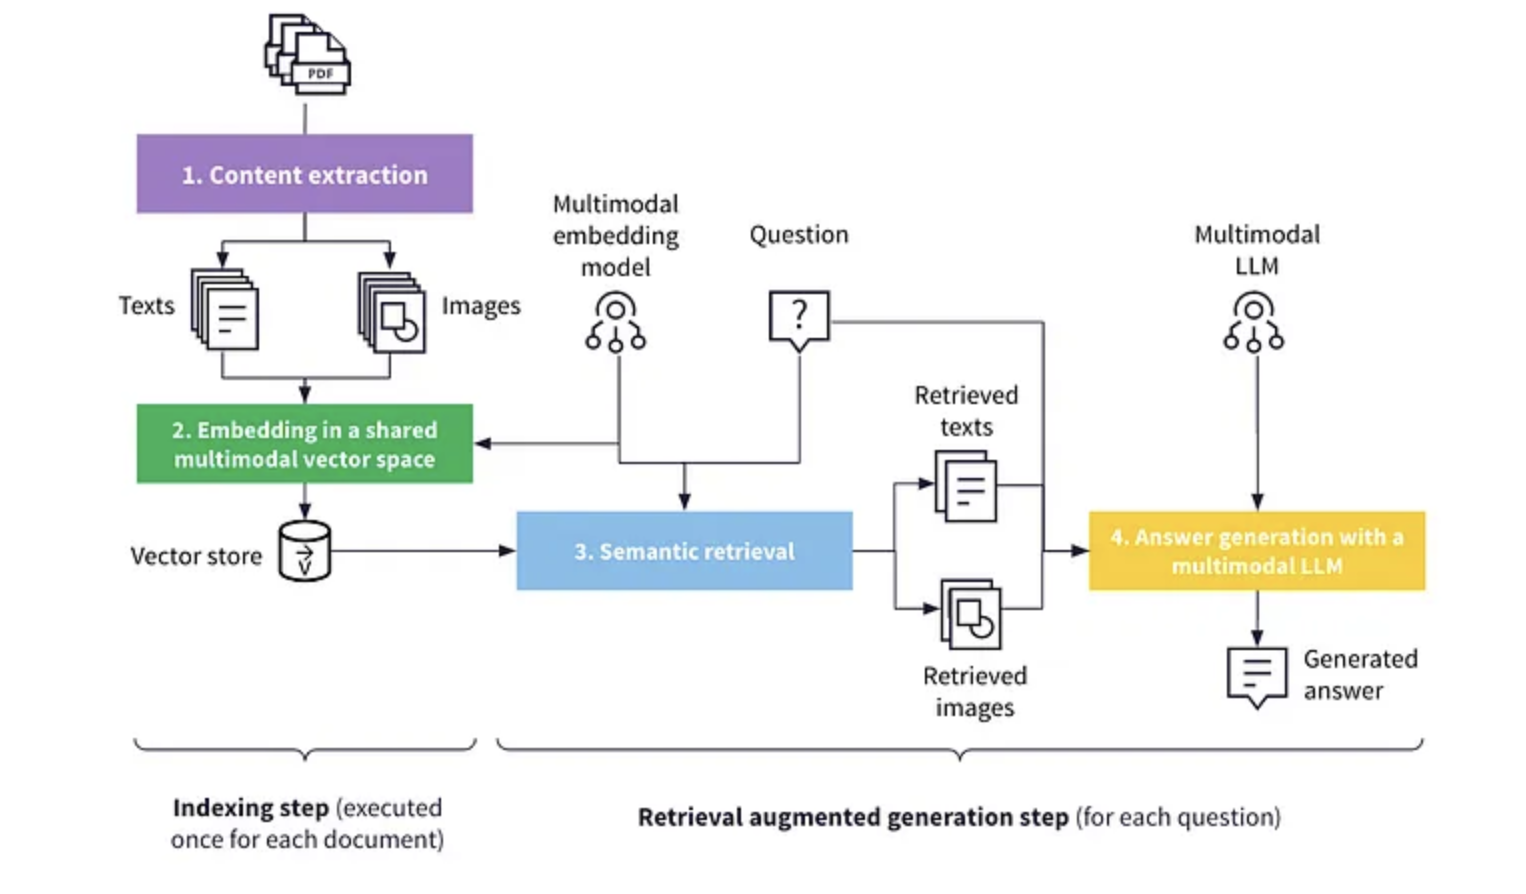

In [5]:
texts, images = extract_text_and_images_from_pdf(pdf_path)

for i, text in enumerate(texts):
    print(f"Text from Page {i+1}:")
    print(text)
    print("-" * 50)

for i, img in enumerate(images):
    display(img)

In [6]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# split text into size of max_length tokens = 77
def split_text_into_chunks(text, chunk_size=77):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# embed text
def embed_text(texts, max_length=77):
    embeddings = []
    for text in texts:
        text_chunks = split_text_into_chunks(text, max_length)  # Split text into chunks
        for chunk in text_chunks:
            inputs = clip_processor(text=[chunk], return_tensors="pt", padding=True, truncation=True)
            embedding = clip_model.get_text_features(**inputs)
            embeddings.append(embedding)
    # Concatenate embeddings of all chunks
    return torch.cat(embeddings, dim=0)


In [11]:
text_embeddings = embed_text(texts)
image_embeddings = embed_images(images)

In [12]:
text_embeddings

tensor([[-0.1065,  0.3664, -0.0725,  ...,  0.4407,  0.2046,  0.0268],
        [ 0.0972,  0.2421, -0.2188,  ..., -0.0236,  0.2763,  0.1502],
        [-0.0927,  0.4450, -0.0835,  ...,  0.0262,  0.3599, -0.1730],
        ...,
        [ 0.2147, -0.5110, -0.2323,  ...,  0.4424, -0.2712, -0.0373],
        [-0.2867,  0.2060,  0.1094,  ...,  0.2728, -0.0389, -0.1795],
        [ 0.1969,  0.0497,  0.0696,  ...,  0.3852,  0.4100, -0.1798]],
       grad_fn=<CatBackward0>)

In [13]:
image_embeddings

tensor([[ 4.9201e-01, -2.1545e-01,  3.7156e-01, -2.4171e-01, -3.5832e-01,
          4.7151e-02,  1.2201e-01,  2.0715e-01,  6.8081e-01,  3.0011e-01,
         -4.4345e-02, -1.0999e-01,  1.1767e-01,  3.6917e-01,  3.2707e-01,
         -1.2650e-01, -2.3529e-01,  4.8740e-01, -5.1716e-01, -1.4057e-02,
          7.0760e-01, -1.3639e-01,  3.3998e-01,  6.3591e-01, -2.6298e-01,
          8.8370e-02, -2.2628e-01, -2.5346e-02, -1.0907e-01, -4.1635e-02,
         -1.4055e-01,  1.9916e-01,  7.2652e-02,  9.1473e-02,  6.9155e-01,
          4.2071e-01, -9.5185e-02,  2.8040e-01,  1.6475e-01, -1.3992e+00,
         -3.1554e-01,  4.8274e-02, -2.0554e-01,  1.1921e-01,  6.7691e-02,
         -3.5205e-01, -2.9653e-01,  1.8501e-01,  1.7744e-01,  2.7740e-01,
          1.6057e-01, -1.0500e-01,  3.5657e-01,  1.0778e-01, -2.7764e-01,
         -9.3791e-02,  3.3408e-02, -4.3042e-02,  5.1854e-01,  3.4328e-01,
         -1.6783e-01, -2.9297e-01,  3.9250e-01,  1.5224e-01,  3.6287e-02,
         -2.0934e-01,  7.1225e-02, -1.